In [33]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
plt.style.use('ggplot') 
import seaborn as sns 
sns.set_style('whitegrid') 
%matplotlib inline 

import warnings 
warnings.filterwarnings('ignore') 
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 
pd.set_option ('precision', 3)
pd.set_option ('display.float_format', lambda x: '%.3f'%x)

In [34]:
dat = pd.read_csv('LoanStats_2017Q4.csv',header=1)
dat = dat[:-2]
dat.drop(['id','member_id'], axis=1, inplace=True)

# response variable

In [35]:
def loan_statu(s):
    if s=='Charged Off':
        a=1
    elif s=='Late (16-30 days)':
        a=1
    elif s=='Late (31-120 days)':
        a=1
    elif s=='In Grace Period':
        a=1
    else:
        a=0
    return a
dat['loan_status']=dat['loan_status'].apply(loan_statu)

# Spliting

In [4]:
#x_col = dat.columns.tolist()
#x_col.remove('loan_status')
#x = dat[x_col]
#y = dat['loan_status']
#from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0) 
#df_train =pd.concat([x_train, y_train], axis=1) 
#df_test =pd.concat([x_test, y_test], axis=1)

# Missing data

Delete columns whose missing rate was more than 60%.Their attributes had little significance for model prediction.

In [36]:
check_null = dat.isnull().sum().sort_values(ascending=False)/float(len(dat)) 
print(check_null[check_null > 0.6])

desc                                         1.000
url                                          1.000
orig_projected_additional_accrued_interest   1.000
hardship_dpd                                 1.000
hardship_type                                1.000
hardship_reason                              1.000
deferral_term                                1.000
hardship_amount                              1.000
hardship_start_date                          1.000
hardship_end_date                            1.000
payment_plan_start_date                      1.000
hardship_length                              1.000
hardship_status                              1.000
hardship_loan_status                         1.000
hardship_last_payment_amount                 1.000
hardship_payoff_balance_amount               1.000
settlement_date                              1.000
settlement_percentage                        1.000
settlement_amount                            1.000
settlement_term                

In [37]:
mis_feas=[i for i in dat.columns if ((dat[i].isnull().sum())*1.0/dat.shape[0])>0.6]
mis_feas.remove('mths_since_last_record')
dat.drop(mis_feas,axis=1,inplace=True)
#df_list=[df_train,df_test]
#for i in df_list:
#    i.drop(mis_feas,axis=1,inplace=True)

In [38]:
dat.int_rate=dat.int_rate.str.strip("%").astype(float)
dat.revol_util=dat.revol_util.str.strip("%").astype(float)

In [8]:
#for i in df_list:
#    i.int_rate=i.int_rate.str.strip("%").astype(float)
#    i.revol_util=i.revol_util.str.strip("%").astype(float)

##  Object type

In [39]:
objectColumns=dat.select_dtypes(include=['object']).columns
dat[objectColumns].isnull().sum().sort_values(ascending=True)

term                        0
hardship_flag               0
application_type            0
initial_list_status         0
earliest_cr_line            0
addr_state                  0
zip_code                    0
disbursement_method         0
purpose                     0
title                       0
issue_d                     0
verification_status         0
home_ownership              0
sub_grade                   0
grade                       0
pymnt_plan                  0
debt_settlement_flag        0
last_credit_pull_d          5
last_pymnt_d              174
emp_length               9722
emp_title                9869
next_pymnt_d            12014
dtype: int64

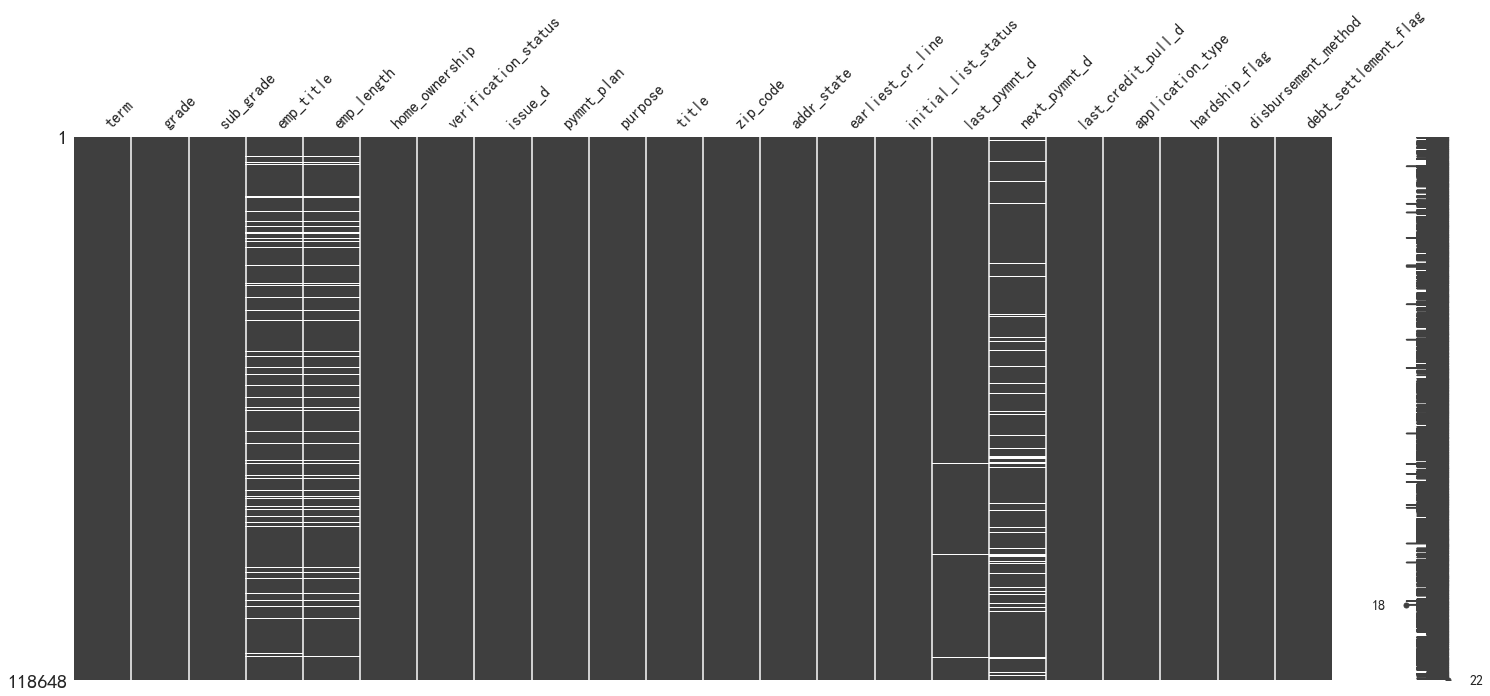

In [40]:
import missingno as msno
msno.matrix(dat[objectColumns])

In [41]:
dat[objectColumns] = dat[objectColumns].fillna(method='bfill')

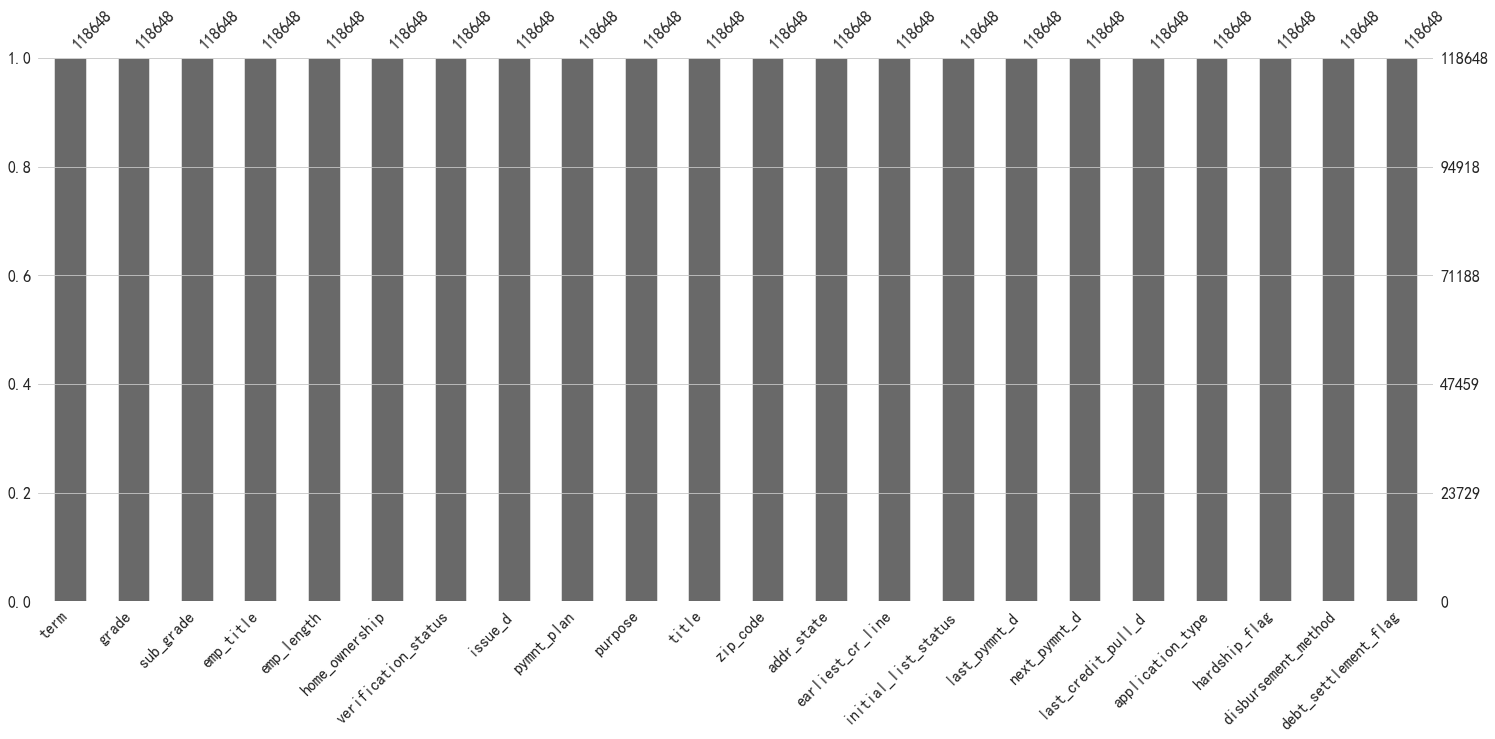

In [42]:
msno.bar(dat[objectColumns])

##  Numeric type

In [43]:
numColumns=dat.select_dtypes(include=[np.number]).columns
dat[numColumns].isnull().sum().sort_values(ascending=True)

loan_amnt                          0
mort_acc                           0
mo_sin_rcnt_tl                     0
mo_sin_rcnt_rev_tl_op              0
mo_sin_old_rev_tl_op               0
delinq_amnt                        0
chargeoff_within_12_mths           0
num_accts_ever_120_pd              0
acc_open_past_24mths               0
total_cu_tl                        0
inq_fi                             0
total_rev_hi_lim                   0
max_bal_bc                         0
total_bc_limit                     0
open_rv_12m                        0
inq_last_12m                       0
total_bal_il                       0
num_actv_bc_tl                     0
num_bc_sats                        0
total_bal_ex_mort                  0
tot_hi_cred_lim                    0
tax_liens                          0
pub_rec_bankruptcies               0
pct_tl_nvr_dlq                     0
num_tl_op_past_12m                 0
num_actv_rev_tl                    0
num_tl_90g_dpd_24m                 0
n

In [44]:
from sklearn.impute import SimpleImputer
imr = SimpleImputer(missing_values=np.nan, strategy='most_frequent')  
imr = imr.fit(dat[numColumns])
dat[numColumns] = imr.transform(dat[numColumns])

In [15]:
#for i in df_list:
#    i[objectColumns] = i[objectColumns].fillna(method='bfill')
#    imr = imr.fit(i[numColumns])
#    i[numColumns] = imr.transform(i[numColumns])

# Filting 

'sub_grade': Duplicate information with Grade      
'zip_code': incomplete; meaningless    
'last_credit_pull_d': The latest time for the platform to offer loans    
'pymnt_plan': mostly n    
'title': Duplicate information with purpose     
'next_pymnt_d': meaningless     
'collection_recovery_fee': 0, meaningless    
'issue_d',  When the loan was issued; give away information to the model in advance            'last_pymnt_d','collection_recovery_fee','last_pymnt_amnt': After-credit information    

In [45]:
drop_list=['sub_grade', 'title',
           'emp_title','next_pymnt_d',
           'addr_state',
           'zip_code',
           'policy_code','pymnt_plan','hardship_flag',
           'collection_recovery_fee','collections_12_mths_ex_med','debt_settlement_flag',
           'last_pymnt_d','last_pymnt_amnt','last_credit_pull_d','total_rec_late_fee',
           'total_rec_prncp','recoveries','total_rec_int','funded_amnt_inv',
           'funded_amnt','total_pymnt','total_pymnt_inv']

In [46]:
dat.drop(drop_list,axis=1,inplace=True)

In [18]:
#for i in df_list:
#    i.drop(drop_list,axis=1,inplace=True)

# Adding and changing

installment_feat: a customer's monthly installment/monthly income     
annual_inc         
cre_hist

In [47]:
dat['installment_feat'] = dat['installment']/(dat['annual_inc']+1/12)

In [48]:
def icomerage(s):
    if s <= 30000:
        b='Low Income'
    elif (s>30000) & (s<=60000):
        b='Medium Income'
    elif (s>60000) & (s<=90000):
        b='High Income'
    elif (s>90000) & (s<=120000):
        b='Most Income'
    else:
        b='Super Income'
    return b
dat['annual_inc']=dat['annual_inc'].apply(icomerage)
dat['annual_inc'].value_counts()

Medium Income    43515
High Income      32997
Most Income      16149
Super Income     15337
Low Income       10650
Name: annual_inc, dtype: int64

In [49]:
from datetime import datetime
dat.issue_d=[pd.datetime.strptime(i, '%b-%Y') for i in dat.issue_d]
dat.earliest_cr_line=[pd.datetime.strptime(i, '%b-%Y') for i in dat.earliest_cr_line]
dat['cre_hist']=[i.days for i in (dat.issue_d-dat.earliest_cr_line)/30]
dat=dat.drop(['issue_d','earliest_cr_line'],axis=1)

In [22]:
#for i in df_list:
#    i['annual_inc']=i['annual_inc'].apply(icomerage)
#    i.issue_d=[pd.datetime.strptime(j, '%b-%Y') for j in i.issue_d]
#    i.earliest_cr_line=[pd.datetime.strptime(j, '%b-%Y') for j in i.earliest_cr_line]
#    i['cre_hist']=[j.days for j in (i.issue_d-i.earliest_cr_line)/30]
#    i=i.drop(['issue_d','earliest_cr_line'],axis=1)

In [50]:
dat.select_dtypes(include=['object']).describe().T

count unique                 top    freq
term                 118648      2           36 months   82677
grade                118648      7                   B   36832
emp_length           118648     11           10+ years   41379
home_ownership       118648      4            MORTGAGE   57060
annual_inc           118648      5       Medium Income   43515
verification_status  118648      3        Not Verified   47745
purpose              118648     13  debt_consolidation   62452
initial_list_status  118648      2                   w   96864
application_type     118648      2          Individual  101437
disbursement_method  118648      2                Cash  115065

# Object type

## ordered variable

In [51]:
mapping_dict = {
    'emp_length':{
        '10+ years':10,
        '9 years':9,
        '8 years':8,
        '7 years':7,
        '6 years':6,
        '5 years':5,
        '4 years':4,
        '3 years':3,
        '2 years':2,
        '1 year':1,
        '< 1 year':0
    },
    'grade':{
        'A':1,
        'B':2,
        'C':3,
        'D':4,
        'E':5,
        'F':6,
        'G':7
    },
    'annual_inc':{
        'Low Income':1,
        'Medium Income':2,
        'High Income':3,
        'Most Income':4,
        'Super Income':5
    }
}

In [52]:
dat = dat.replace(mapping_dict)
dat[['emp_length','grade','annual_inc']].head()

emp_length  grade  annual_inc
0           2      2           5
1           4      3           3
2          10      2           3
3          10      4           5
4           0      1           3

In [26]:
#for i in df_list:
#    i = i.replace(mapping_dict)

## unordered variable

In [53]:
n_columns=['term','home_ownership','verification_status',
           'purpose','initial_list_status',
           'application_type','disbursement_method']

In [54]:
dummy_df=pd.get_dummies(dat[n_columns])
dat=pd.concat([dat,dummy_df],axis=1)

In [55]:
dat.loc[:,dat.columns.str.contains('home_ownership')].head()

home_ownership  home_ownership_ANY  home_ownership_MORTGAGE  \
0            OWN                   0                        0   
1           RENT                   0                        0   
2       MORTGAGE                   0                        1   
3       MORTGAGE                   0                        1   
4       MORTGAGE                   0                        1   

   home_ownership_OWN  home_ownership_RENT  
0                   1                    0  
1                   0                    1  
2                   0                    0  
3                   0                    0  
4                   0                    0

In [90]:
dummy_df.columns

Index(['term_ 36 months', 'term_ 60 months', 'home_ownership_MORTGAGE',
       'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'initial_list_status_f', 'initial_list_status_w',
       'application_type_Individual', 'application_type_Joint App',
       'disbursement_method_Cash', 'disbursement_method_DirectPay'],
      dtype='object')

In [57]:
dat = dat.drop(n_columns,axis=1)
dat=dat.drop(['term_ 36 months','home_ownership_MORTGAGE',
          'verification_status_Not Verified','purpose_car',
         'initial_list_status_f','application_type_Individual',
         'disbursement_method_Cash'],axis=1)

In [31]:
#for i in df_list:
#    dummy_df=pd.get_dummies(i[n_columns])
#    i=pd.concat([i,dummy_df],axis=1)
#    i.drop(n_columns,axis=1,inplace=True)

# numeric type

In [58]:
dat[['loan_status']]=dat[['loan_status']].astype(int)
dat[['cre_hist']]=dat[['cre_hist']].astype(float)

In [59]:
column=dat.select_dtypes(include=['float64']).columns

In [60]:
len(column)

70

In [61]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118648 entries, 0 to 118647
Data columns (total 95 columns):
loan_amnt                              118648 non-null float64
int_rate                               118648 non-null float64
installment                            118648 non-null float64
grade                                  118648 non-null int64
emp_length                             118648 non-null int64
annual_inc                             118648 non-null int64
loan_status                            118648 non-null int32
dti                                    118648 non-null float64
delinq_2yrs                            118648 non-null float64
inq_last_6mths                         118648 non-null float64
mths_since_last_delinq                 118648 non-null float64
mths_since_last_record                 118648 non-null float64
open_acc                               118648 non-null float64
pub_rec                                118648 non-null float64
revol_bal      

In [62]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
loans_ml_df = dat
loans_ml_df[column]=ss.fit_transform(loans_ml_df[column])
loans_ml_df.head()

loan_amnt  int_rate  installment  grade  emp_length  annual_inc  \
0      0.470    -0.576        0.690      2           2           5   
1      0.470     0.614        0.136      3           4           3   
2     -0.534    -0.385       -0.424      2          10           3   
3     -1.056     1.013       -0.961      4          10           5   
4     -0.032    -1.203        0.047      1           0           3   

   loan_status    dti  delinq_2yrs  inq_last_6mths  ...  \
0            0 -0.539       -0.316           0.632  ...   
1            0 -0.091        3.500          -0.643  ...   
2            0 -0.258        2.228          -0.643  ...   
3            0  0.565       -0.316          -0.643  ...   
4            0 -0.309       -0.316          -0.643  ...   

   purpose_major_purchase  purpose_medical  purpose_moving  purpose_other  \
0                       0                0               0              0   
1                       0                0               0              0   
2                       0                0               0              1   
3                       0                0               0              0   
4                       0                0               0              0   

   purpose_renewable_energy  purpose_small_business  purpose_vacation  \
0                         0                       0                 0   
1                         0                       0                 0   
2                         0                       0                 0   
3                         0                       0                 0   
4                         0                       0                 0   

   initial_list_status_w  application_type_Joint App  \
0                      1                           0   
1                      1                           0   
2                      1                           0   
3                      1                           0   
4                      1                           0   

   disbursement_method_DirectPay  
0                              0  
1                              0  
2                              0  
3                              0  
4                              0  

[5 rows x 95 columns]

In [ ]:
#for i in df_list:
#    i[['loan_status']]=i[['loan_status']].astype(int)
#    i[['cre_hist']]=i[['cre_hist']].astype(float)
#    i['installment_feat'][np.isinf(i['installment_feat'])] = 100
#    loans_ml_df_x = i
#    loans_ml_df_x[column]=ss.fit_transform(loans_ml_df[column])

# reduce dimension

In [64]:
x_feature=list(loans_ml_df.columns)
x_feature.remove('loan_status')
x_val=loans_ml_df[x_feature]
y_val=loans_ml_df['loan_status']
len(x_feature)

94

In [69]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model=LogisticRegression()
rfe=RFE(model,n_features_to_select=30)
rfe=rfe.fit(x_val,y_val)
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True False False False False  True False False  True
 False False False False  True  True False False False False False False
 False False  True False False False False False False False False False
 False False  True  True False False False False False False False False
  True False False  True  True False False False False  True  True False
 False False False False False False False False False  True  True  True
 False  True False  True  True  True  True  True  True False False False
 False False  True False False  True  True False  True False]
[ 1  1  1  1 44 29 51 58  1 49 37  1 20 33 41 63  1  1 46 62 60 25 39  6
 11 32  1 23  5 26  7 24  4 34 12 53 10  9  1  1 36 47 31 40 54 50 27 42
  1 35 18  1  1 22 59  8 45  1  1 13 52 56  3 61  2 21 19 30 48  1  1  1
 28  1 65  1  1  1  1  1  1 57 16 15 64 43  1 17 55  1  1 14  1 38]


In [70]:
col_filter=x_val.columns[rfe.support_]
col_filter

Index(['loan_amnt', 'int_rate', 'installment', 'grade', 'inq_last_6mths',
       'open_acc', 'out_prncp', 'out_prncp_inv', 'total_bal_il',
       'bc_open_to_buy', 'bc_util', 'mths_since_recent_inq', 'num_actv_rev_tl',
       'num_bc_sats', 'num_rev_tl_bal_gt_0', 'num_sats', 'total_bc_limit',
       'total_il_high_credit_limit', 'installment_feat', 'term_ 60 months',
       'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_moving',
       'purpose_small_business', 'purpose_vacation',
       'application_type_Joint App'],
      dtype='object')

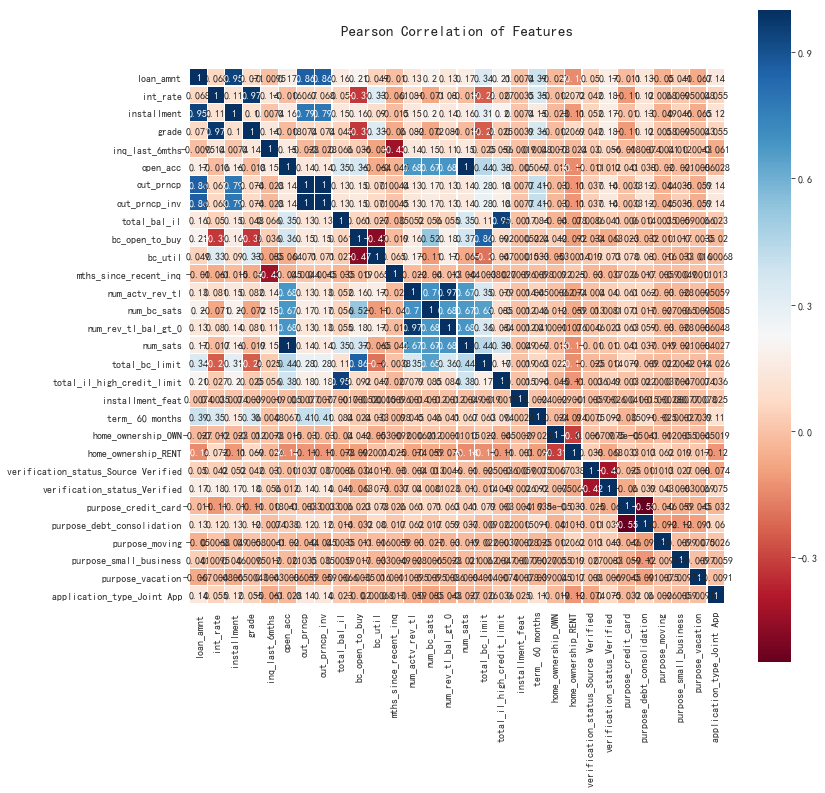

In [71]:
colormap = plt.cm.RdBu
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15) 
sns.heatmap(loans_ml_df[col_filter].corr(),linewidths=0.1,vmax=1.0,square=True, cmap=colormap, linecolor='white', annot=True)

In [72]:
'''
int_rate VS grade
num_rev_tl_bal_gt_0 VS num_actv_rev_tl
loan_amnt VS out_prncp,installment,out_prncp_inv
open_acc VS num_sats
total_il_high_credit_limit VS total_bal_il
total_bc_limit VS bc_open_to_buy

'''
drop_col=['grade','num_actv_rev_tl','out_prncp',
          'num_sats','installment',
          'total_bal_il','bc_open_to_buy']

In [73]:
col_new=col_filter.drop(drop_col)

In [74]:
len(col_new)

23

## VIF

In [75]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
vif_ls=[]
for i in range(len(col_new)):
    vif_ls.append([col_new[i],vif(loans_ml_df[col_new].values,i)])
vif_df=pd.DataFrame(vif_ls,columns=['col_name','vif'])
vif_df.sort_values(by='vif',ascending=False)

col_name   vif
0                             loan_amnt 4.248
4                         out_prncp_inv 4.008
7                           num_bc_sats 3.396
3                              open_acc 2.973
8                   num_rev_tl_bal_gt_0 2.724
18           purpose_debt_consolidation 2.189
9                        total_bc_limit 2.171
12                      term_ 60 months 1.847
14                  home_ownership_RENT 1.772
15  verification_status_Source Verified 1.611
17                  purpose_credit_card 1.512
16         verification_status_Verified 1.467
1                              int_rate 1.454
5                               bc_util 1.380
10           total_il_high_credit_limit 1.377
2                        inq_last_6mths 1.313
6                 mths_since_recent_inq 1.231
22           application_type_Joint App 1.210
13                   home_ownership_OWN 1.206
19                       purpose_moving 1.037
20               purpose_small_business 1.035
21                     purpose_vacation 1.021
11                     installment_feat 1.001

## IV

In [141]:
def CalWOE(df,col,target):
    total=df.groupby([col])[target].count()
    total=pd.DataFrame({'total':total})
    bad=df.groupby([col])[target].sum()
    bad=pd.DataFrame({'bad':bad})
    regroup=total.merge(bad,left_index=True,right_index=True,how='left')
    regroup.reset_index(level=0,inplace=True)
    N=sum(regroup['total'])
    B=sum(regroup['bad'])
    regroup['good']=regroup['total']-regroup['bad']
    G=N-B
    regroup['bad_pcnt']=regroup['bad'].map(lambda x:x*1.0/B)
    regroup['good_pcnt']=regroup['good'].map(lambda x:x*1.0/G)
    regroup['WOE']=regroup.apply(lambda x:np.log(x.good_pcnt*1.0/x.bad_pcnt),axis=1)
    WOE_dict=regroup[[col,'WOE']].set_index(col).to_dict()
    IV=regroup.apply(lambda x:(x.good_pcnt-x.bad_pcnt)*np.log(x.good_pcnt*1.0/x.bad_pcnt),axis=1)
    IV_SUM=sum(IV)
    return {'WOE':WOE_dict,'IV_sum':IV_SUM,'IV':IV}

In [142]:
iv_list=[]
for i in col_new:
    iv_dict=CalWOE(pd.concat([loans_ml_df[col_new],loans_ml_df['loan_status']],axis=1),i,'loan_status')
    iv_list.append(iv_dict['IV_sum'])
iv_df=pd.DataFrame({'iv_name':loans_ml_df[col_new].columns.values,'iv':iv_list})
iv_df.sort_values('iv',ascending=False)

iv_name    iv
0                             loan_amnt   inf
7                           num_bc_sats   inf
1                              int_rate   inf
10           total_il_high_credit_limit   inf
9                        total_bc_limit   inf
8                   num_rev_tl_bal_gt_0   inf
11                     installment_feat   inf
6                 mths_since_recent_inq   inf
5                               bc_util   inf
4                         out_prncp_inv   inf
3                              open_acc   inf
2                        inq_last_6mths 0.083
16         verification_status_Verified 0.057
17                  purpose_credit_card 0.035
12                      term_ 60 months 0.023
22           application_type_Joint App 0.013
14                  home_ownership_RENT 0.011
20               purpose_small_business 0.011
19                       purpose_moving 0.003
13                   home_ownership_OWN 0.003
18           purpose_debt_consolidation 0.001
15  verification_status_Source Verified 0.001
21                     purpose_vacation 0.000

In [46]:
#from sklearn.decomposition import PCA
#pca = PCA(n_components=0.9)
#pca.transform(loans_ml_df)

array([[-3.37531096,  1.43062467, -0.1631986 , ..., -1.80512831,
        -0.8834769 ,  0.3189343 ],
       [-3.56832056, -4.10571878,  1.38266348, ..., -0.81892763,
         0.42710971, -0.4957938 ],
       [ 3.65819312, -3.67628285,  2.12886959, ..., -0.67675975,
         1.05824416, -0.57455141],
       ...,
       [ 2.85482216, -4.68834686,  1.73927724, ...,  0.49585644,
        -0.12259023,  1.0312254 ],
       [-3.04367139,  0.41644771, -0.78063777, ..., -0.90991254,
        -0.61555711, -0.49879076],
       [-2.32045341,  2.09576378, -2.95511579, ..., -0.49129128,
         0.67500049,  0.103676  ]])

In [98]:
#pd.DataFrame(names).to_excel('features.xlsx')
#loans_ml_df[col_new].to_excel('clean data.xlsx')
#loans_ml_df['loan_status'].to_excel('target.xlsx')

# Feature importance

In [76]:
names=loans_ml_df[col_new].columns
from sklearn.ensemble import RandomForestClassifier

In [99]:
len(names)

23

In [101]:
clf=RandomForestClassifier(n_estimators=10,random_state=123)
clf.fit(x_val[col_new],y_val)
for feature in zip(names,clf.feature_importances_):
    print(feature)

('loan_amnt', 0.08343427636122341)
('int_rate', 0.07410071559020422)
('inq_last_6mths', 0.018366164014960804)
('open_acc', 0.06594301755808014)
('out_prncp_inv', 0.10864070902206976)
('bc_util', 0.10056832414934351)
('mths_since_recent_inq', 0.0522324330534056)
('num_bc_sats', 0.054008749584756474)
('num_rev_tl_bal_gt_0', 0.05161629880232173)
('total_bc_limit', 0.09544164290318868)
('total_il_high_credit_limit', 0.09320704039351521)
('installment_feat', 0.10613537726373108)
('term_ 60 months', 0.010112125078880981)
('home_ownership_OWN', 0.009300837476875014)
('home_ownership_RENT', 0.015323015669157447)
('verification_status_Source Verified', 0.012580941820480885)
('verification_status_Verified', 0.010561847248383079)
('purpose_credit_card', 0.007308980944245383)
('purpose_debt_consolidation', 0.013544210361769934)
('purpose_moving', 0.0029357294034361757)
('purpose_small_business', 0.004094890979568856)
('purpose_vacation', 0.0017562435543926318)
('application_type_Joint App', 0.0087

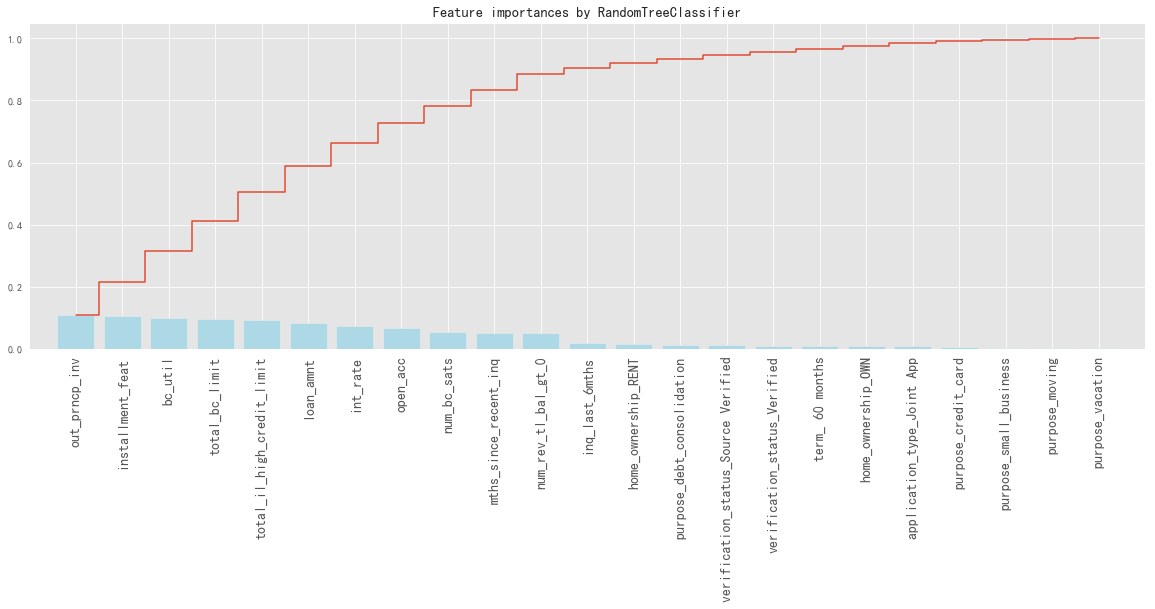

In [102]:
plt.style.use('ggplot')

importances = clf.feature_importances_
feat_names = names
indices = np.argsort(importances)[::-1]
fig = plt.figure(figsize=(20,6))
plt.title("Feature importances by RandomTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

# SMOTE

In [93]:
X = loans_ml_df[col_new]
y = loans_ml_df['loan_status']

n_sample=y.shape[0]
n_pos_sample=y[y==0].shape[0]
n_neg_sample=y[y==1].shape[0]
print('samples size: {}  positive sample: {:2%}  negtive sample: {:2%}'.format(n_sample,
                                                                       n_pos_sample/n_sample,
                                                                        n_neg_sample/n_sample))
print('dimension:',X.shape[1])

samples size: 118648  positive sample: 96.294923%  negtive sample: 3.705077%
dimension: 23


In [82]:
from imblearn.over_sampling import SMOTE
sm=SMOTE(random_state=42)
X,y=sm.fit_resample(X,y)
print('After rebalancing:')
n_sample=y.shape[0]
n_pos_sample=y[y==0].shape[0]
n_neg_sample=y[y==1].shape[0]
print('samples size: {}  positive sample: {:2%}  negtive sample: {:2%}'.format(n_sample,
                                                                               n_pos_sample/n_sample,
                                                                               n_neg_sample/n_sample))
print('dimension:',X.shape[1])

After rebalancing:
samples size: 228504  positive sample: 50.000000%  negtive sample: 50.000000%
dimension: 23


In [94]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_curve 
from sklearn.metrics import RocCurveDisplay 
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [95]:
clf1=LogisticRegression()
clf1.fit(X_train,y_train)
clf1.score(X_test,y_test)

0.9642365500772581